<a href="https://colab.research.google.com/github/sergekamanzi/Fraudent-Docs/blob/main/transaction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**IMPORTING LIBRARIES**

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

**LOADING DATA**

In [28]:
data = pd.read_csv('/content/fraud detection.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,380.0,CASH_OUT,92888.94,C2054348498,27657.00,0.00,C1853199806,5838781.76,5931670.70,0.0,0.0
1,646.0,TRANSFER,399045.08,C724693370,10399045.08,10399045.08,C1909486199,0.00,0.00,1.0,1.0
2,384.0,CASH_IN,35416.73,C1095508813,1154711.52,1190128.25,C961243143,927932.70,892515.97,0.0,0.0
3,518.0,CASH_IN,52211.31,C1867780533,2985.00,55196.31,C1425168473,433652.93,381441.62,0.0,0.0
4,450.0,CASH_OUT,1463764.35,C2142422300,1463764.35,0.00,C1173885211,385211.95,1848976.30,1.0,0.0


**DATA PROCESSING**

In [3]:
# to see unique values of column type
unique_values = data['type'].unique()
print(unique_values)

['CASH_OUT' 'TRANSFER' 'CASH_IN' 'PAYMENT' 'DEBIT']


In [5]:
#%%capture
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,7050.000000,7.050000e+03,7.050000e+03,7.050000e+03,7.050000e+03,7.050000e+03,7050.000000,7050.000000
mean,285.255177,5.425332e+05,1.018520e+06,6.381589e+05,9.555733e+05,1.273450e+06,0.290780,0.000567
std,174.266294,1.533102e+06,3.013717e+06,2.684439e+06,4.286751e+06,4.897417e+06,0.454154,0.023815
min,6.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,163.000000,2.188457e+04,1.712300e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,265.000000,1.265790e+05,4.957450e+04,0.000000e+00,2.623340e+03,1.586073e+05,0.000000,0.000000
75%,379.000000,3.291337e+05,4.133118e+05,3.295994e+04,6.995410e+05,1.077128e+06,1.000000,0.000000
max,743.000000,2.515081e+07,4.489219e+07,3.489219e+07,2.772997e+08,2.916677e+08,1.000000,1.000000


In [6]:
%%capture
data.isnull().sum()

In [7]:
%%capture
data = data.drop(columns=["nameOrig", "nameDest", "isFlaggedFraud"])
data.head()

In [8]:
#%%capture
# Initialize LabelEncoder
le = LabelEncoder()

# Apply LabelEncoder to the 'type' column
data['type'] = le.fit_transform(data['type'])
data.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,380.0,1,92888.94,27657.00,0.00,5838781.76,5931670.70,0.0
1,646.0,4,399045.08,10399045.08,10399045.08,0.00,0.00,1.0
2,384.0,0,35416.73,1154711.52,1190128.25,927932.70,892515.97,0.0
3,518.0,0,52211.31,2985.00,55196.31,433652.93,381441.62,0.0
4,450.0,1,1463764.35,1463764.35,0.00,385211.95,1848976.30,1.0


In [22]:
# to see the encoded values that turned into integers
#type_mapping = {
#   1: 'CASH_OUT',
#   4: 'TRANSFER',
#   0: 'CASH_IN',
#   3: 'PAYMENT',
#   2: 'DEBIT'
#}


unique_values = data['type'].unique()
print(unique_values)

[1 4 0 3 2]


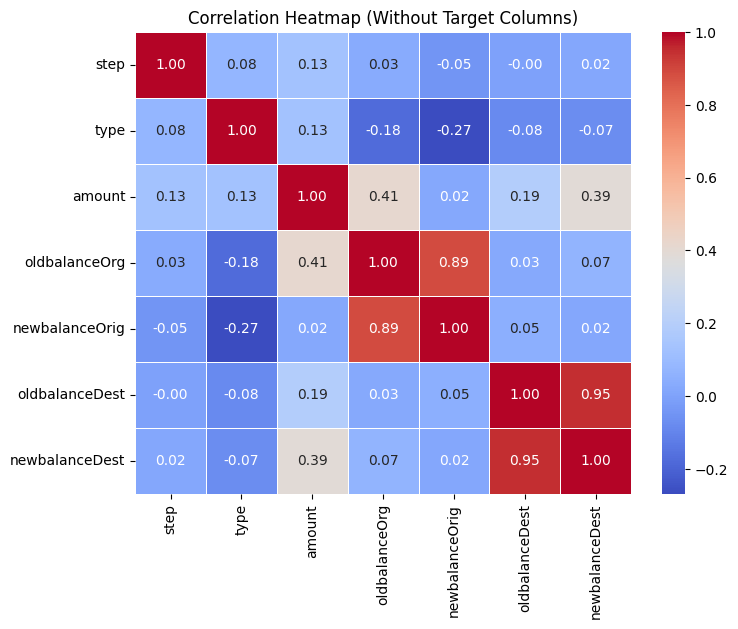

In [10]:
# Compute the correlation matrix
corr_matrix = data.drop(columns=['isFraud']).corr()

# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Without Target Columns)')
plt.show()


In [11]:
data.shape

(7050, 8)

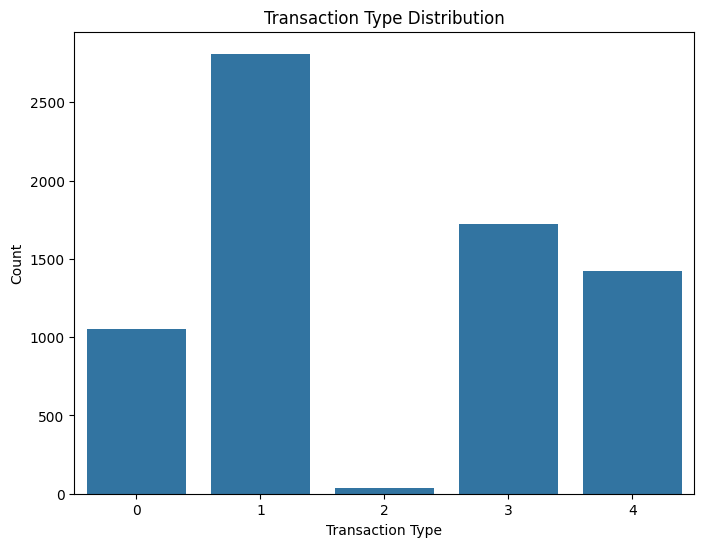

In [19]:
# Count the occurrences of each transaction type
plt.figure(figsize=(8, 6))
sns.countplot(x='type', data=data)
plt.title('Transaction Type Distribution')
plt.xlabel('Transaction Type')
plt.ylabel('Count')
plt.show()


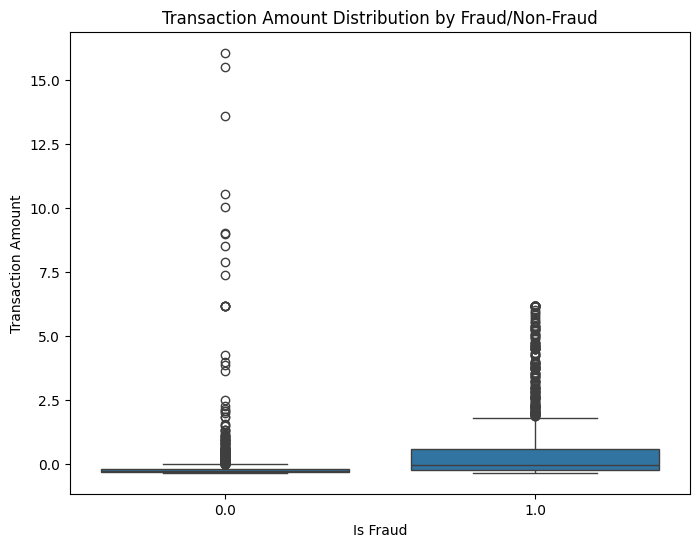

In [20]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='isFraud', y='amount', data=data)
plt.title('Transaction Amount Distribution by Fraud/Non-Fraud')
plt.xlabel('Is Fraud')
plt.ylabel('Transaction Amount')
plt.show()


In [12]:
# Initialize the StandardScaler
scaler = StandardScaler()

# List of numeric columns to scale (excluding target variables like isFraud)
numeric_cols = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Apply the scaler to the numeric columns
data[numeric_cols] = scaler.fit_transform(data[numeric_cols])

In [13]:
# features and target labels
X = data.drop(columns=['isFraud'])
Y = data['isFraud']

In [14]:
# Split data into train, validation, and test sets
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=42)

# Compute class weights
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(Y_train), y=Y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [15]:
# Neural Network model
model = Sequential([
    Dense(64, activation='relu', kernel_regularizer=l2(0.01), input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(1, activation='sigmoid')
])


In [16]:
# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Define Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [17]:
%%capture
# Train model
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=50, batch_size=32,
                    class_weight=class_weight_dict, callbacks=[early_stopping], verbose=1)

# Evaluate model
Y_pred = (model.predict(X_test) > 0.5).astype("int32")

In [33]:
# Compute metrics
accuracy = accuracy_score(Y_test, Y_pred)
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Confusion Matrix:\n", conf_matrix)


Accuracy: 0.9480151228733459
Precision: 0.9434628975265018
Recall: 0.8725490196078431
F1 Score: 0.9066213921901528
Confusion Matrix:
 [[736  16]
 [ 39 267]]


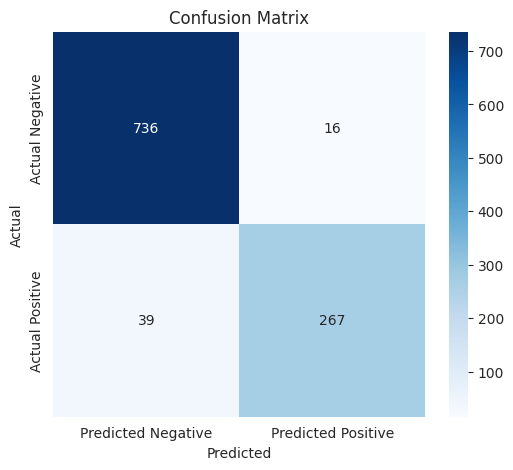

In [37]:
# Create the heatmap for the confusion matrix
conf_matrix = [[736, 16], [39, 267]]
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [42]:
import joblib

# 1. Save the Neural Network Model in the recommended .keras format
model.save('fraud_detection_model.keras')
# 2. Save the StandardScaler
joblib.dump(scaler, 'standard_scaler.pkl')

['standard_scaler.pkl']

**PYTHON SCRIPT**

In [ ]:
# Function to predict fraud based on user input
def predict_fraud():
    print("Enter transaction details below:")
    step = float(input("Step: "))
    type_ = int(input("Type (Enter 0 for CASH_IN, 1 for CASH_OUT, etc.): "))
    amount = float(input("Amount: "))
    oldbalanceOrg = float(input("Old Balance Origin: "))
    newbalanceOrig = float(input("New Balance Origin: "))
    oldbalanceDest = float(input("Old Balance Destination: "))
    newbalanceDest = float(input("New Balance Destination: "))

    user_input = pd.DataFrame([[step, type_, amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest]],
                              columns=X.columns)
    user_input[numeric_cols] = scaler.transform(user_input[numeric_cols])
    prediction = (model.predict(user_input) > 0.5).astype("int32")[0, 0]

    print("Prediction:", "Fraud" if prediction == 1 else "No Fraud")

# Run prediction function
predict_fraud()


Enter transaction details below:
Step: 646.0	
Type (Enter 0 for CASH_IN, 1 for CASH_OUT, etc.): 4
Amount: 399045.08	
Old Balance Origin: 10399045.08
New Balance Origin: 10399045.08
Old Balance Destination: 0.00	
New Balance Destination: 0.00	
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Prediction: Fraud
